In [1]:
pip install yfinance xgboost pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb



In [5]:
data = yf.download("AAPL", start="2015-01-01", end="2023-12-31")
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.dropna(inplace=True)
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.746226,24.757334,23.848706,24.288580,212818400
2015-01-05,24.057535,24.137513,23.417720,23.604332,257142000
2015-01-06,23.668756,23.866477,23.244433,23.606552,263188400
2015-01-07,23.815381,24.037539,23.704302,23.937569,160423600
2015-01-08,24.266365,24.915067,24.148620,24.857306,237458000


In [6]:
data['Return'] = data['Close'].pct_change()
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['Volatility'] = data['Return'].rolling(window=5).std()
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)  # 1 = buy, 0 = sell

data.dropna(inplace=True)
data.tail()


Price,Open,High,Low,Close,Volume,Return,MA5,MA10,MA20,Volatility,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2023-12-22,193.761066,193.989405,191.567141,192.192566,37122800,-0.005547,193.769009,194.323944,192.260555,0.006438,0
2023-12-26,192.202487,192.480450,191.428159,191.646561,28919300,-0.002841,193.205142,194.311041,192.422370,0.005934,1
2023-12-27,191.090644,192.093296,189.700813,191.745834,48087700,0.000518,192.452655,194.156175,192.558871,0.004460,1
2023-12-28,192.728625,193.244849,191.765676,192.172699,34049900,0.002226,192.204471,193.721359,192.767841,0.003018,0
2023-12-29,192.490361,192.986726,190.336138,191.130325,42628800,-0.005424,191.777597,193.167415,192.895904,0.003500,0


In [7]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'MA20', 'Volatility']
X = data[features]
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [8]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.46993318485523383
              precision    recall  f1-score   support

           0       0.46      0.65      0.54       213
           1       0.49      0.31      0.38       236

    accuracy                           0.47       449
   macro avg       0.48      0.48      0.46       449
weighted avg       0.48      0.47      0.45       449



/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:12:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
test_data = data.iloc[-len(y_test):].copy()
test_data['Prediction'] = y_pred
test_data['Strategy_Return'] = test_data['Return'] * test_data['Prediction'].shift(1)
test_data['Cumulative_Market_Return'] = (1 + test_data['Return']).cumprod()
test_data['Cumulative_Strategy_Return'] = (1 + test_data['Strategy_Return']).cumprod()


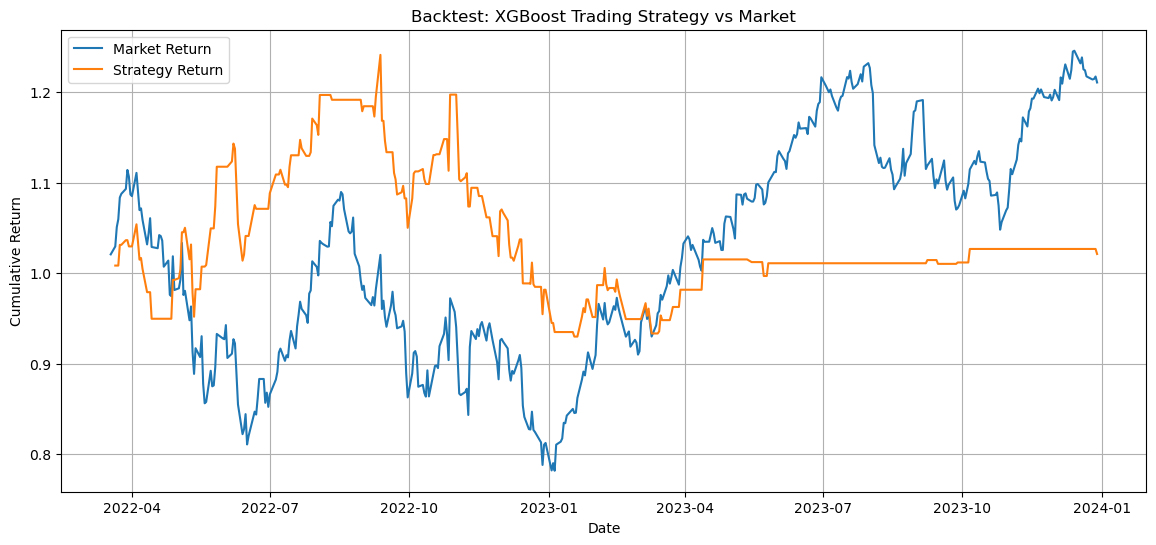

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(test_data['Cumulative_Market_Return'], label='Market Return')
plt.plot(test_data['Cumulative_Strategy_Return'], label='Strategy Return')
plt.title('Backtest: XGBoost Trading Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
print("Final Strategy Return:", test_data['Cumulative_Strategy_Return'].iloc[-1])
print("Final Market Return:", test_data['Cumulative_Market_Return'].iloc[-1])


Final Strategy Return: 1.021323199732715
Final Market Return: 1.210820920951119
